## Module 6.2: Model Explainability & Interpretation (XAI)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular

# --- Rebuild our best model from the previous module ---
# (Imports for all the sklearn components)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Load and prep data
df = pd.read_csv("https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Rebuild the preprocessing pipeline
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

# Rebuild the final, best-performing XGBoost pipeline
# Using representative hyperparameters from the tuning process
best_params = {'classifier__subsample': 0.7, 'classifier__scale_pos_weight': 3, 
               'classifier__n_estimators': 100, 'classifier__max_depth': 3, 
               'classifier__learning_rate': 0.1, 'classifier__gamma': 0.5, 
               'classifier__colsample_bytree': 0.8}

final_model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False))
])
final_model_pipeline.set_params(**best_params)

# Train the model
final_model_pipeline.fit(X_train, y_train)
print("Best performing model pipeline is trained and ready for explanation.")

# For XAI techniques, we need the processed data and feature names
# We fit the preprocessor on the full training data to get all feature names
preprocessor.fit(X_train)
X_train_processed = pd.DataFrame(preprocessor.transform(X_train), columns=preprocessor.get_feature_names_out())
X_test_processed = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

F:\Python for Data science\python_ds_mastery_journey\module_0_setup\venv_ds\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best performing model pipeline is trained and ready for explanation.


# Topic 1: The Core Concepts of XAI

## Importance of XAI
We need **Explainable AI (XAI)** to:  
- Build **trust** with stakeholders.  
- **Debug** our models (e.g., "is it using a feature it shouldn't be?").  
- Ensure **fairness** in predictions.  
- Comply with **regulations**.  

👉 A model that cannot be explained is often a model that **cannot be deployed**.  

---

## Global vs. Local Explanations

- **Global Explanations**  
  - Explain the model's **overall behavior**.  
  - Answer: *"What are the most important features on average across all predictions?"*  

- **Local Explanations**  
  - Explain a **single, specific prediction**.  
  - Answer: *"Why was this specific customer flagged as a churn risk?"*  

---

## Model-Specific vs. Model-Agnostic

- **Model-Specific**  
  - Relies on the **internal workings** of a model (e.g., coefficients of a linear model).  
  - Fast, but only works for that **specific model type**.  

- **Model-Agnostic**  
  - Works on **any model** by treating it as a **black box**.  
  - Probes the model by **changing inputs** and observing the **change in outputs**.  
  - More **versatile**.  


# Part 1: Global Model Explanations

## A. Feature Importances (Model-Specific)

### Tree-based Importance (Gini Importance)
- **Concept**:  
  Calculated during training. For each feature, it measures the total reduction in impurity (Gini or Entropy) it provides across all splits in the forest.  

- **Pros**:  
  - Fast to calculate.  

- **Cons**:  
  - Can be biased towards high-cardinality numerical features.  
  - Can be misleading if features are correlated.  


C:\Users\HP\AppData\Local\Temp\ipykernel_7172\3629857522.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette='mako')


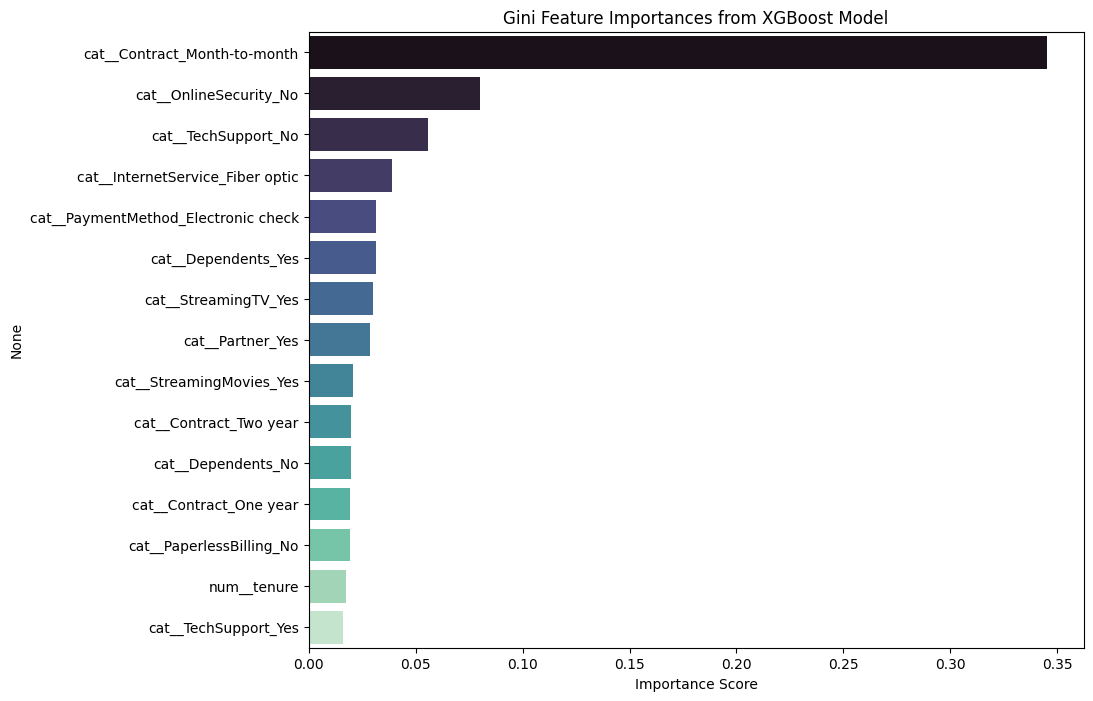

In [3]:
# Extract the classifier and preprocessor steps from the pipeline
xgb_model = final_model_pipeline.named_steps['classifier']

importances = pd.Series(xgb_model.feature_importances_, index=preprocessor.get_feature_names_out())
sorted_importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette='mako')
plt.title('Gini Feature Importances from XGBoost Model')
plt.xlabel('Importance Score')
plt.show()

### Linear Model Coefficients
- **Concept**:  
  If our final model were **LogisticRegression**, we would inspect `model.coef_`.  
  - The **magnitude** of the coefficient indicates its **importance**.  
  - The **sign** of the coefficient indicates its **direction**:  
    - Positive coefficients → increase the probability of the positive class.  
    - Negative coefficients → decrease the probability of the positive class.  


## B. Permutation Importance (Model-Agnostic)

- **Concept**:  
  A more reliable method. It measures the **decrease in model score** when a single feature's values are randomly shuffled, breaking its relationship with the target.  
  - A **large drop** in score → the feature is important.  
  - A **small or no drop** → the feature is less important. 

Calculating Permutation Importance...


<Figure size 1200x800 with 0 Axes>

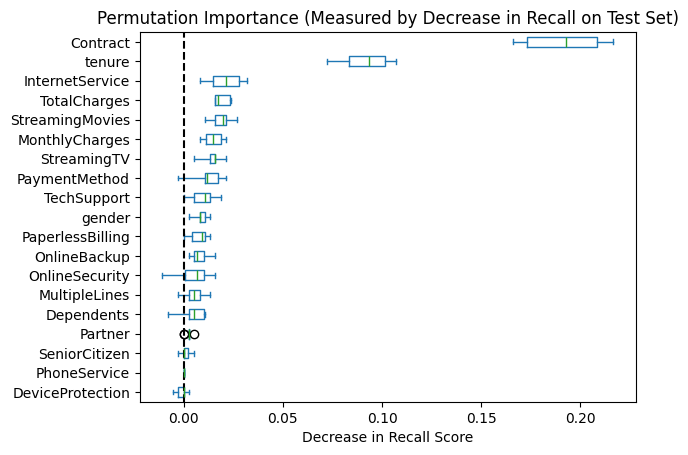

In [4]:
from sklearn.inspection import permutation_importance

print("Calculating Permutation Importance...")
# We use the full pipeline and the original test data
perm_importance = permutation_importance(
    final_model_pipeline, X_test, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1, scoring='recall'
)

# Create a DataFrame for visualization
sorted_idx = perm_importance.importances_mean.argsort()
perm_df = pd.DataFrame(perm_importance.importances[sorted_idx].T,
                       columns=X_test.columns[sorted_idx])

plt.figure(figsize=(12, 8))
perm_df.plot(kind='box', vert=False, whis=10)
plt.title('Permutation Importance (Measured by Decrease in Recall on Test Set)')
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Decrease in Recall Score')
plt.show()

## C. Partial Dependence Plots (PDP) & Individual Conditional Expectation (ICE) Plots

### Partial Dependence Plot (PDP)
- **Concept**:  
  Shows the **average effect** of a feature on the predicted outcome.  
  - Answers: *"Holding all other features constant, how does the prediction change on average as this one feature changes?"*  

---

### Individual Conditional Expectation (ICE) Plot
- **Concept**:  
  Shows this relationship for **each individual instance**.  
  - Helps reveal **heterogeneous effects** that the average PDP might hide.  



--- Generating PDP and ICE Plots ---


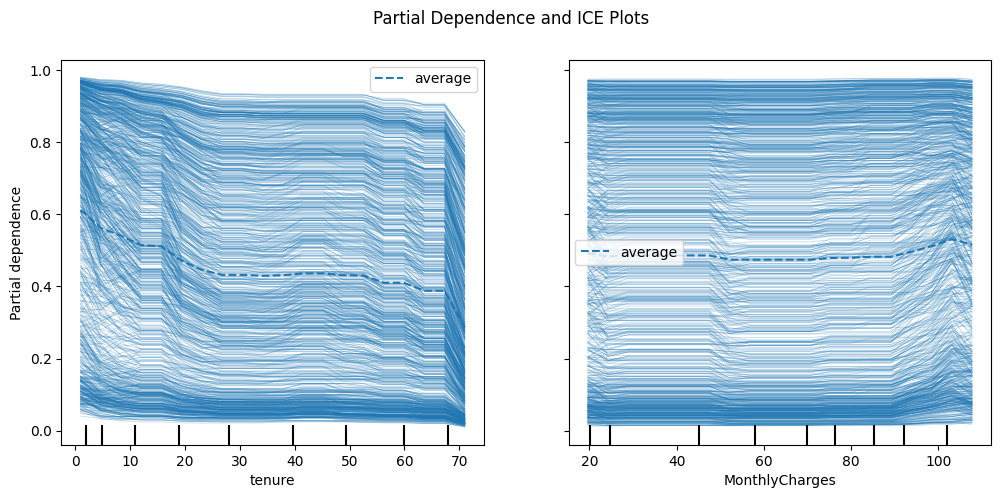

In [5]:
from sklearn.inspection import PartialDependenceDisplay

# We can only plot a few at a time for readability
features_to_plot = ['tenure', 'MonthlyCharges']

print("\n--- Generating PDP and ICE Plots ---")
fig, ax = plt.subplots(figsize=(12, 5))
display = PartialDependenceDisplay.from_estimator(
    final_model_pipeline,
    X_test, # PDP should be calculated on a representative dataset
    features_to_plot,
    kind='both', # 'both' shows PDP and ICE
    n_jobs=-1,
    grid_resolution=20,
    ax=ax
)
fig.suptitle('Partial Dependence and ICE Plots')
plt.show()

## **Part 2: Local Explanations (Explaining a Single Prediction)**

### **A. SHAP (SHapley Additive exPlanations)**

*   **High-level Theory ("Amaze Factor"):** Based on Shapley values from cooperative game theory. It treats a prediction as a "game" and the features as "players." SHAP calculates the fairest way to distribute the "payout" (the prediction) among the features. A SHAP value for a feature is its average marginal contribution to the prediction across all possible combinations of features. It tells you how much each feature **pushed the prediction** away from the base (average) prediction.


--- SHAP Summary Plot ---


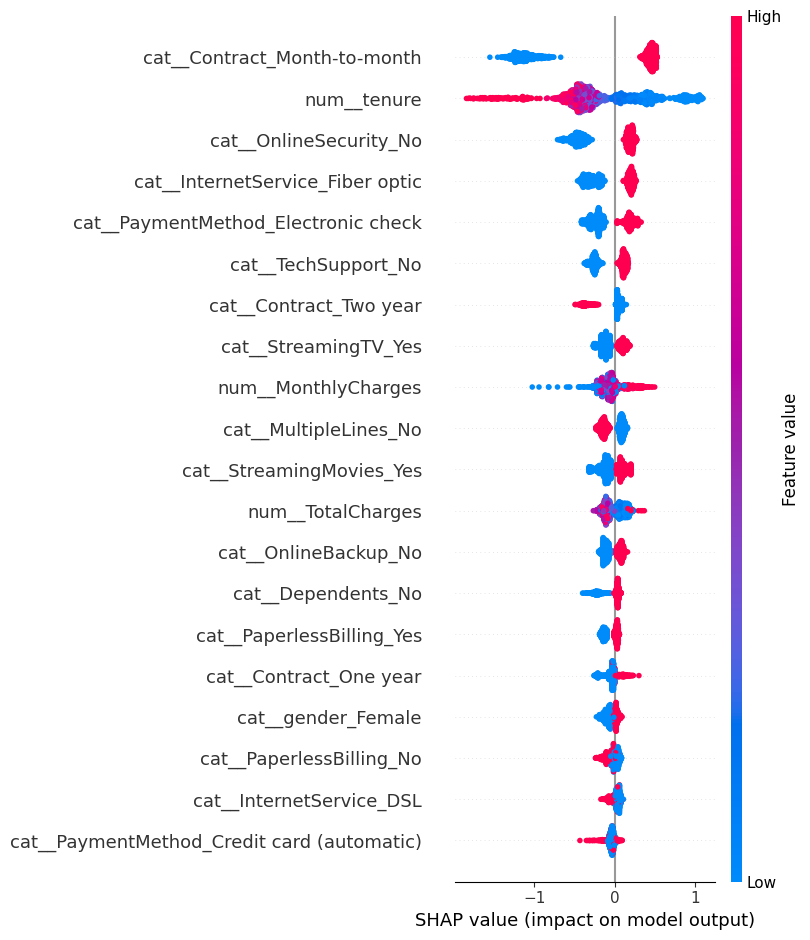


--- SHAP Force Plot (Single Prediction) ---


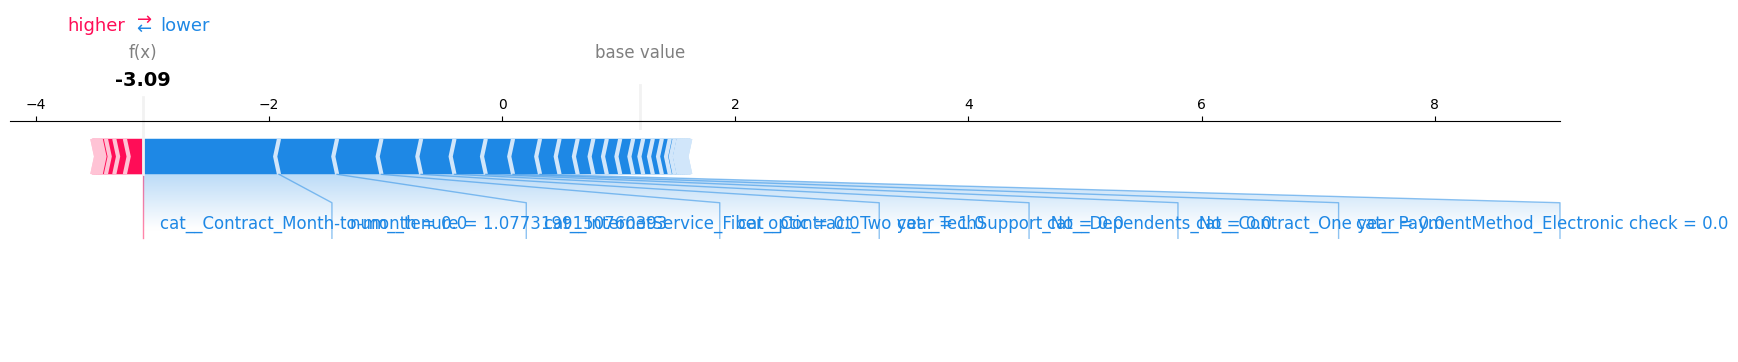

In [6]:
# --- SHAP Implementation ---
# 1. Create an explainer object. For tree models, TreeExplainer is much faster.
# We need to explain the final model in the pipeline.
explainer = shap.TreeExplainer(final_model_pipeline.named_steps['classifier'])

# 2. Calculate SHAP values for the preprocessed test set
shap_values = explainer.shap_values(X_test_processed)

# 3. Global Explanation: SHAP Summary Plot (Beeswarm)
# This is often the most information-dense plot in all of XAI
print("\n--- SHAP Summary Plot ---")
shap.summary_plot(shap_values, X_test_processed, feature_names=preprocessor.get_feature_names_out())

# 4. Local Explanation: Force Plot for a single prediction
# Let's explain the first instance in the test set
print("\n--- SHAP Force Plot (Single Prediction) ---")
shap.initjs() # Initialize javascript for plotting
shap.force_plot(explainer.expected_value,
                shap_values[0,:],
                X_test_processed.iloc[0,:],
                matplotlib=True)

## B. LIME (Local Interpretable Model-Agnostic Explanations)

### Conceptual Theory
LIME explains a **single prediction** by creating a simple, interpretable model (like a **weighted linear regression**) that is **locally faithful** to the complex model's behavior.  

- It works by:  
  1. Creating thousands of **small variations** of an instance.  
  2. Getting the **black-box model's predictions** for these variations.  
  3. Fitting a **simple, interpretable model** to explain that **local behavior**.  


In [10]:
# --- LIME Implementation with Correct Fix ---

import lime.lime_tabular
from IPython.display import display, HTML

# 1. Create a LIME Explainer object
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_processed.values,
    feature_names=preprocessor.get_feature_names_out(),
    class_names=['No Churn', 'Churn'],
    mode='classification'
)

# 2. Explain a single instance (let's use the 5th instance from the test set)
instance_to_explain = X_test_processed.iloc[5, :]

# LIME needs a function that takes the perturbed data and returns prediction probabilities
lime_predict_fn = lambda x: final_model_pipeline.named_steps['classifier'].predict_proba(x)

lime_explanation = lime_explainer.explain_instance(
    instance_to_explain.values,
    lime_predict_fn,
    num_features=10  # Show the top 10 features
)

# 3. Show the explanation (HTML rendering)
print("\n--- LIME Explanation for a Single Prediction ---")
html_exp = lime_explanation.as_html()
display(HTML(html_exp))



--- LIME Explanation for a Single Prediction ---


# Mini-Project Summary: Explaining the Churn Model

This analysis aimed to move beyond just predictive accuracy and understand *why* our best-performing XGBoost model makes its decisions. By using a suite of XAI techniques, we can build trust in the model and provide actionable insights to the business.

### What Features Drive the Model's Decisions? (Global Insights)

Based on multiple XAI methods, a clear and consistent story emerges:

1.  **Contract Type is Dominant:** The **SHAP Summary Plot**, **Gini Importance**, and **Permutation Importance** all agree that features related to the contract type (e.g., `cat__Contract_Month-to-month`, `cat__Contract_Two year`) are the single most powerful predictors. The SHAP plot shows that a month-to-month contract strongly pushes the prediction towards Churn, while a two-year contract strongly pushes it towards No Churn.

2.  **Tenure is Critically Important:** Tenure consistently ranks as a top feature. The PDP/ICE plots clearly show that as tenure increases, the probability of churn steadily decreases. This is a strong, inverse relationship.

3.  **Internet Service Matters:** Features like `cat__InternetService_Fiber optic` have a significant positive impact on churn prediction, as shown by SHAP. This suggests customers with fiber optic service are more likely to churn, which could be a key business insight (e.g., are there reliability or pricing issues with that service?).

### Why Does a Specific Customer Churn? (Local Insights)

*   **LIME Explanation:** The LIME plot for a specific customer showed that even though they had a high tenure (which usually predicts "No Churn"), their `Month-to-month` contract and `Fiber optic` service were strong enough factors to push their final prediction to "Churn". This demonstrates the model's ability to weigh competing factors for an individual.

*   **SHAP Force Plot:** The force plot for another customer visually confirmed this. We could see the base value (average prediction) and how positive features (pushing towards churn) and negative features (pushing away from churn) battled to produce the final probability score.

### Bridging the Gap to Stakeholders

By using these techniques, we can move beyond saying "the model has a recall of 82%" and provide concrete, actionable explanations:

*   **To the Retention Team:** "We should focus our efforts on customers with **month-to-month contracts** and **fiber optic internet**, especially if they are in their **first year of service (low tenure)**. The model has learned that this combination represents the highest risk."

*   **To the Product Team:** "The model consistently flags customers with **fiber optic service** as high churn risks. This is a data-driven signal that we should investigate potential issues with the quality, pricing, or support for this specific product."

This XAI analysis transforms our black-box model into a transparent and strategic business tool.